# Word2Vec Embeddings+Classification

Here, we use Word2Vec to generate the embeddings of our recipes, starting by the embeddings of their respective ingredients. <br>
Then, we perform the classification task both in the single-label and multilabel case, by using standard machine learning classifiers i.e. logistic regression, SVM, random forest and MLP. 

# Imports

In [1]:
import pandas as pd
import numpy as np

from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE

from gensim.models import word2vec   #required gensim 4.3.2

from sklearn.ensemble import RandomForestClassifier 
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report,multilabel_confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.multioutput import MultiOutputClassifier

from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import ParameterGrid
from tqdm import tqdm
from keras.callbacks import EarlyStopping
from keras.regularizers import l2
from keras.optimizers import Adam
from keras.models import Sequential
from keras.layers import Dense
import keras

First, we take the 'ingredients_list_stanza_10k', obtained in the NER notebook, and trace its labels back through 'dataset_balanced_10k'. Then, we just remove the empty recipes and save the new labels dataframe.

In [2]:
path='./dataset/ingredients_list_stanza_10k.csv'
df=pd.read_csv(path)

In [3]:
df.head(2)

,0,1,2,3,4,5,6,7,8,9,...,33,34,35,36,37,38,39,40,41,42
0,maple syrup,garlic,ginger,cayenne pepper,raisin,sage leave,vinegar,mustard,olive oil,clove,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,lime juice,grenadine syrup,cayenne pepper,juice,salt,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
df.shape

(10000, 43)

In [5]:
df2= pd.read_csv('./dataset/dataset_balanced_10k.csv')

In [6]:
df2.columns

Index(['cooking_method', 'ingredients', 'tags', 'Vegetarian', 'Dairy Free',
       'Gluten Free', 'Low Carb', 'Low Fat', 'Low Sodium', 'Dessert', 'Meat',
       'Fish', 'Dairy', 'Vegetarian&Dessert', 'Meat&Fish'],
      dtype='object')

In [7]:
labels_col=['Vegetarian', 'Dairy Free',
       'Gluten Free', 'Low Carb', 'Low Fat', 'Low Sodium', 'Dessert', 'Meat',
       'Fish', 'Dairy', 'Vegetarian&Dessert', 'Meat&Fish']

In [8]:
df2=df2[labels_col]

Let's detect and remove all the empty recipes.

In [9]:
empty=[]
for i in df.index:
        val=df['0'][i]
        if (type(val) == float and np.isnan(val)):
            empty.append(i)

In [10]:
len(empty)

45

In [11]:
df.drop(empty,inplace=True)
df2.drop(empty,inplace=True)

Let's just check one more time that they both have the same number of examples.

In [12]:
print(df.shape[0],'\n', df2.shape[0])

9955 
 9955


Finally, we can save our labels to use them later for classification.

In [13]:
df2.to_csv('./dataset/labels_stanza_10k.csv',index=False)

From now on, we will apply word2vec and classification on the current df.

# Word2Vec embeddings

We need to create the corpus as a list of sentences, where each sentence is the list of ingredients of each recipe.

In [14]:
corpus=[]
for i in df.index:
    list=[]
    for j in df.columns:
        val=df[j][i]
        if not (type(val) == float and np.isnan(val)):
            list.append(val)
    corpus.append(list)

In [15]:
len(corpus)

9955

In [23]:
text = " "
for lst in corpus:
    for word in lst:
        text+=' '
        text+=word

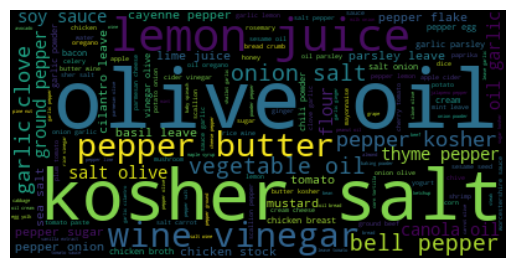

In [27]:
from wordcloud import WordCloud
# Create and generate a word cloud image:
wordcloud = WordCloud().generate(text)

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [16]:
embed_sz=100
window_sz=df.shape[1]
model = word2vec.Word2Vec(corpus, vector_size=embed_sz, window=window_sz, min_count=1, workers=4)

Given a word W in the corpus, we can check the most similar words to W 

In [17]:
#example of the 20 most similar words to a random word in the corpus
sims = model.wv.most_similar('milk', topn=20) 
sims

[('flour', 0.9949302077293396),
 ('nutmeg', 0.9926518797874451),
 ('egg', 0.9898886680603027),
 ('elbow macaroni', 0.9766780138015747),
 ('butter', 0.9736327528953552),
 ('yeast', 0.9665468335151672),
 ('cake flour', 0.9549593329429626),
 ('ground ginger', 0.9476879239082336),
 ('dough', 0.9461484551429749),
 ('buttermilk', 0.942431628704071),
 ('gruyere cheese', 0.9423742890357971),
 ('yolk', 0.9401503801345825),
 ('cooking spray', 0.9400683045387268),
 ('egg yolk', 0.9393607378005981),
 ('cream cheese', 0.9350089430809021),
 ('lemon rind', 0.9332150816917419),
 ('light cream', 0.9283549785614014),
 ('gruyere', 0.9281796216964722),
 ('tartar', 0.9278096556663513),
 ('pumpkin', 0.927729070186615)]

Let's do a 2D visualization of 100 ingredients via TSNE.

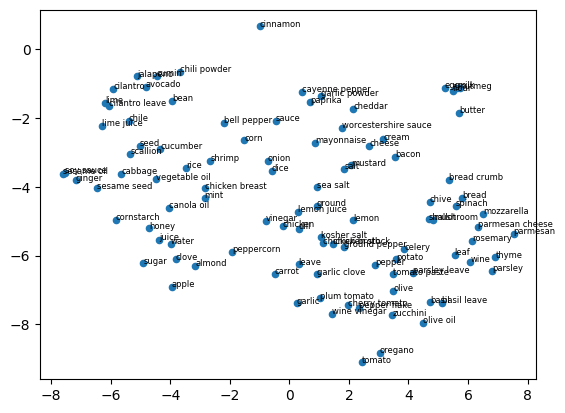

In [18]:
labels = []
count = 0
max_count = 100
X = np.zeros(shape=(max_count,embed_sz))

for term in model.wv.index_to_key:
    X[count] = model.wv[term]
    labels.append(term)
    count+= 1
    if count >= max_count: break

# It is recommended to use PCA first to reduce to ~50 dimensions
pca = PCA(n_components=50)
X_50 = pca.fit_transform(X)

# Using TSNE to further reduce to 2 dimensions
model_tsne = TSNE(n_components=2, random_state=0)
Y = model_tsne.fit_transform(X_50)

# Show the scatter plot
plt.scatter(Y[:,0], Y[:,1], 20)

# Add labels
for label, x, y in zip(labels, Y[:, 0], Y[:, 1]):
    plt.annotate(label, xy = (x,y), xytext = (0, 0), textcoords = 'offset points', size = 6)

plt.show()

Finally, we create the matrix where each row is the embedding of a recipe, each given by the midpoint in the space of its ingredients' embeddings.

In [19]:
recipe_embeddings=np.zeros((df.shape[0],embed_sz))

for i,list in enumerate(corpus):
    vec=np.zeros(embed_sz)
    for word in list:
        vec=vec+model.wv[word]
    vec=vec/float(len(list))
    recipe_embeddings[i,:]=vec   

In [20]:
np.savetxt('./dataset/embeddings_stanza_10k.csv',recipe_embeddings,delimiter=',')

# Data splitting and scaling

In [21]:
X_path='./dataset/embeddings_stanza_10k.csv'
X=pd.read_csv(X_path,header=None)

In [22]:
X.shape

(9955, 100)

In [23]:
labels_path='./dataset/labels_stanza_10k.csv'

In [24]:
y=pd.read_csv(labels_path)

In [25]:
y=y['Vegetarian']

In [26]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

In [27]:
scaler = StandardScaler()
X_train_scaled=scaler.fit_transform(X_train)
X_test_scaled=scaler.transform(X_test)

So far, we created our training and test set, with a split of 70%/30%, and stratified with respect to the label. We also used the standard scaler on the two sets.

# Classification on the Vegetarian label

In [28]:
def plot_cm(cm,col):
    print("Confusion Matrix:")
    print(cm)

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap='Blues')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(f'{col}')
    plt.show()

## Logistic Regression

In [29]:
# fitting the model
logreg = LogisticRegression()
logreg.fit(X_train_scaled, y_train)
LogisticRegression()
# predictions
y_pred = logreg.predict(X_test_scaled)
y_pred_train = logreg.predict(X_train_scaled)

c:\Users\Giamm\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [30]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.73      0.79      0.76      1490
           1       0.77      0.71      0.74      1497

    accuracy                           0.75      2987
   macro avg       0.75      0.75      0.75      2987
weighted avg       0.75      0.75      0.75      2987



Confusion Matrix:
[[1170  320]
 [ 436 1061]]


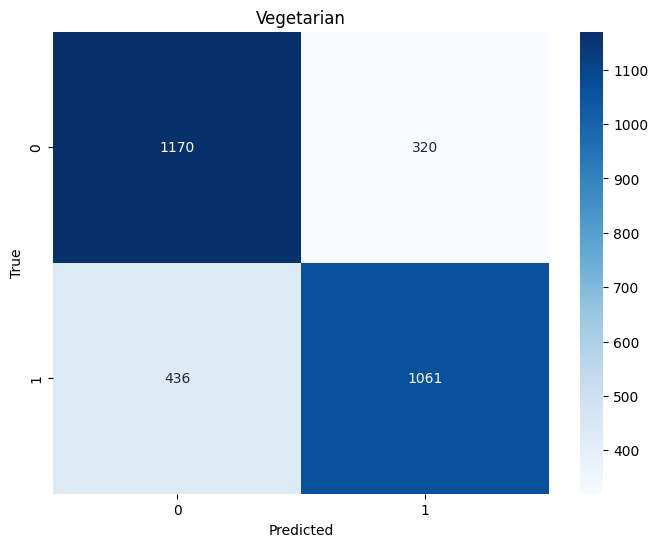

In [31]:
cm=confusion_matrix(y_test, y_pred)
plot_cm(cm,'Vegetarian')

## SVM

In [32]:
param_grid = [
    {'C': [1000,3000,5000], 'gamma': [0.1,0.01,0.001], 'kernel': ['rbf']},
]

svc = SVC()
grid_search = GridSearchCV(svc, param_grid, cv=5, scoring='accuracy', verbose=10, n_jobs=-1)
grid_search.fit(X_train, y_train)

print("Best parameters:", grid_search.best_params_)
print("Best cross-validation score: {:.2f}".format(grid_search.best_score_))

y_pred = grid_search.predict(X_test)
print(classification_report(y_test, y_pred))

Fitting 5 folds for each of 9 candidates, totalling 45 fits
Best parameters: {'C': 5000, 'gamma': 0.1, 'kernel': 'rbf'}
Best cross-validation score: 0.81
              precision    recall  f1-score   support

           0       0.80      0.84      0.82      1490
           1       0.83      0.79      0.81      1497

    accuracy                           0.81      2987
   macro avg       0.82      0.81      0.81      2987
weighted avg       0.82      0.81      0.81      2987



Confusion Matrix:
[[1254  236]
 [ 319 1178]]


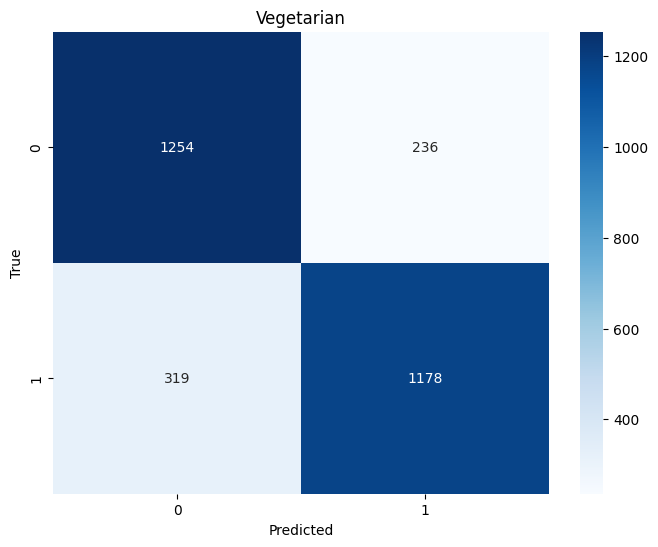

In [33]:
cm=confusion_matrix(y_test, y_pred)
plot_cm(cm,'Vegetarian')

In [34]:
SVM_best_config=grid_search.best_params_

## Random Forest

In [35]:
parameters = {'n_estimators': [50,100,200], 'max_depth':[None], 'min_samples_split':[2], 'min_samples_leaf': [1],'criterion' : ['gini','entropy'] }

grid_search = GridSearchCV(estimator=RandomForestClassifier(), param_grid = parameters, cv=5, verbose=10, scoring='accuracy',n_jobs=-1)

grid_search.fit(X_train, y_train)

print("Best parameters:", grid_search.best_params_)
print("Best cross-validation score: {:.2f}".format(grid_search.best_score_))

y_pred = grid_search.predict(X_test)
print(classification_report(y_test, y_pred))

Fitting 5 folds for each of 6 candidates, totalling 30 fits
Best parameters: {'criterion': 'entropy', 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Best cross-validation score: 0.76
              precision    recall  f1-score   support

           0       0.75      0.81      0.78      1490
           1       0.80      0.73      0.76      1497

    accuracy                           0.77      2987
   macro avg       0.77      0.77      0.77      2987
weighted avg       0.77      0.77      0.77      2987



In [36]:
RF_best_config=grid_search.best_params_

Confusion Matrix:
[[1211  279]
 [ 399 1098]]


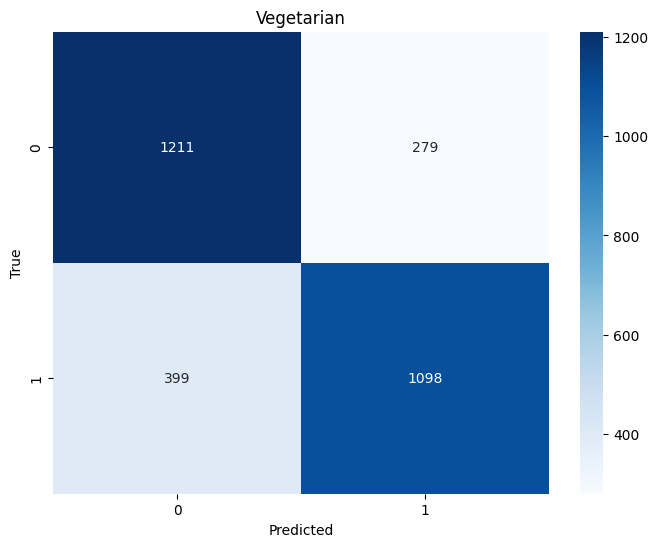

In [37]:
cm=confusion_matrix(y_test, y_pred)
plot_cm(cm,'Vegetarian')

## MLP

In [38]:
param_grid={
    'optimizer': ['adam'],
    'first_layer_size': [ 32, 64],
    'second_layer_size': [16, 32],
    'reg_strength': [0.0001, 0.001, 0.01,],
    'lr':[0.001, 0.0001]
}

In [39]:
def kfold(X, y, k):
    for i in range(k+1):
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=int(X.shape[0]/k), random_state=i)
        yield X_train, X_test, y_train, y_test

def grid_search_kfold(X,y, k, param_grid):
    best_score =0
    X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)
    for params in tqdm(ParameterGrid(param_grid)):
        #train on the k-1 folds

        model =Sequential([
                          Dense(params['first_layer_size'], activation='relu',
                                input_shape=(X.shape[1],), kernel_regularizer=l2(params['reg_strength'])),
                          Dense(params['second_layer_size'], activation='relu', kernel_regularizer=l2(params['reg_strength'])),
                          Dense(1, activation='sigmoid', kernel_regularizer=l2(params['reg_strength']))
                          ]
                        )
        early_stopping= EarlyStopping(patience=5, restore_best_weights=True, monitor='val_loss')
        if params['optimizer']=='adam':
          opt= keras.optimizers.Adam(learning_rate=params['lr'])
        else:
          opt= keras.optimizers.SGD(learning_rate=params['lr'])
          
        model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
        model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=20, callbacks=[early_stopping], verbose=False)
        score = model.evaluate(X_test, y_test)
        print(score)
        if score[1] > best_score:
            best_score = score[1]
            best_params = params
    return best_params, best_score

In [40]:
best_params, best_score = grid_search_kfold(X_train_scaled, y_train, 3, param_grid)

  0%|          | 0/24 [00:00<?, ?it/s]

44/44 [==============================] - 0s 1ms/step - loss: 0.5426 - accuracy: 0.7260


  4%|▍         | 1/24 [00:04<01:44,  4.55s/it]

[0.5426387786865234, 0.7259684205055237]
44/44 [==============================] - 0s 1ms/step - loss: 0.5539 - accuracy: 0.7303


  8%|▊         | 2/24 [00:10<02:04,  5.64s/it]

[0.5538516044616699, 0.7302725911140442]
44/44 [==============================] - 0s 1ms/step - loss: 0.5598 - accuracy: 0.7339


 12%|█▎        | 3/24 [00:17<02:06,  6.03s/it]

[0.5597970485687256, 0.7338594198226929]
44/44 [==============================] - 0s 1ms/step - loss: 0.5473 - accuracy: 0.7396


 17%|█▋        | 4/24 [00:24<02:07,  6.37s/it]

[0.5473185181617737, 0.739598274230957]
44/44 [==============================] - 0s 1ms/step - loss: 0.5933 - accuracy: 0.7174


 21%|██        | 5/24 [00:30<02:00,  6.37s/it]

[0.593250572681427, 0.7173601388931274]
44/44 [==============================] - 0s 1ms/step - loss: 0.5821 - accuracy: 0.7296


 25%|██▌       | 6/24 [00:36<01:51,  6.17s/it]

[0.5820915102958679, 0.7295552492141724]
44/44 [==============================] - 0s 1ms/step - loss: 0.5529 - accuracy: 0.7166


 29%|██▉       | 7/24 [00:42<01:45,  6.22s/it]

[0.5528683662414551, 0.7166427373886108]
44/44 [==============================] - 0s 1ms/step - loss: 0.5491 - accuracy: 0.7188


 33%|███▎      | 8/24 [00:49<01:39,  6.24s/it]

[0.5490845441818237, 0.7187948226928711]
44/44 [==============================] - 0s 1ms/step - loss: 0.6055 - accuracy: 0.7166


 38%|███▊      | 9/24 [00:55<01:34,  6.30s/it]

[0.605539083480835, 0.7166427373886108]
44/44 [==============================] - 0s 1ms/step - loss: 0.6121 - accuracy: 0.7123


 42%|████▏     | 10/24 [01:01<01:27,  6.28s/it]

[0.6121176481246948, 0.7123385667800903]
44/44 [==============================] - 0s 1ms/step - loss: 0.7070 - accuracy: 0.7181


 46%|████▌     | 11/24 [01:08<01:22,  6.33s/it]

[0.7069650292396545, 0.7180774807929993]
44/44 [==============================] - 0s 1ms/step - loss: 0.7628 - accuracy: 0.7181


 50%|█████     | 12/24 [01:14<01:16,  6.41s/it]

[0.7628409266471863, 0.7180774807929993]
44/44 [==============================] - 0s 1ms/step - loss: 0.5366 - accuracy: 0.7317


 54%|█████▍    | 13/24 [01:19<01:04,  5.91s/it]

[0.5366266369819641, 0.7317073345184326]
44/44 [==============================] - 0s 1ms/step - loss: 0.5358 - accuracy: 0.7418


 58%|█████▊    | 14/24 [01:24<00:56,  5.63s/it]

[0.5357611179351807, 0.7417503595352173]
44/44 [==============================] - 0s 1ms/step - loss: 0.5697 - accuracy: 0.7195


 62%|██████▎   | 15/24 [01:30<00:52,  5.83s/it]

[0.5697134733200073, 0.7195122241973877]
44/44 [==============================] - 0s 1ms/step - loss: 0.5486 - accuracy: 0.7382


 67%|██████▋   | 16/24 [01:37<00:47,  5.96s/it]

[0.5485913753509521, 0.7381635308265686]
44/44 [==============================] - 0s 1ms/step - loss: 0.5830 - accuracy: 0.7238


 71%|███████   | 17/24 [01:42<00:39,  5.64s/it]

[0.5830446481704712, 0.7238163352012634]
44/44 [==============================] - 0s 1ms/step - loss: 0.5770 - accuracy: 0.7274


 75%|███████▌  | 18/24 [01:47<00:33,  5.58s/it]

[0.5769758224487305, 0.7274031639099121]
44/44 [==============================] - 0s 3ms/step - loss: 0.5558 - accuracy: 0.7181


 79%|███████▉  | 19/24 [01:53<00:29,  5.87s/it]

[0.5558152198791504, 0.7180774807929993]
44/44 [==============================] - 0s 1ms/step - loss: 0.5414 - accuracy: 0.7310


 83%|████████▎ | 20/24 [02:00<00:24,  6.10s/it]

[0.5413749814033508, 0.730989933013916]
44/44 [==============================] - 0s 1ms/step - loss: 0.6223 - accuracy: 0.7238


 88%|████████▊ | 21/24 [02:07<00:18,  6.22s/it]

[0.6223361492156982, 0.7238163352012634]
44/44 [==============================] - 0s 1ms/step - loss: 0.6352 - accuracy: 0.7260


 92%|█████████▏| 22/24 [02:13<00:12,  6.33s/it]

[0.6352424621582031, 0.7259684205055237]
44/44 [==============================] - 0s 1ms/step - loss: 0.7270 - accuracy: 0.7195


 96%|█████████▌| 23/24 [02:20<00:06,  6.34s/it]

[0.726970374584198, 0.7195122241973877]
44/44 [==============================] - 0s 2ms/step - loss: 0.7642 - accuracy: 0.7274


100%|██████████| 24/24 [02:26<00:00,  6.11s/it]

[0.764162540435791, 0.7274031639099121]


In [41]:
best_params

{'first_layer_size': 64,
 'lr': 0.001,
 'optimizer': 'adam',
 'reg_strength': 0.0001,
 'second_layer_size': 32}

In [42]:
nn = Sequential([
                            Dense(best_params['first_layer_size'], activation='sigmoid',
                                    input_shape=(X_train_scaled.shape[1],), kernel_regularizer=l2(best_params['reg_strength'])),
                            Dense(best_params['second_layer_size'], activation='sigmoid', kernel_regularizer=l2(best_params['reg_strength'])),
                            Dense(1, activation='sigmoid', kernel_regularizer=l2(best_params['reg_strength']))
                            ]
                            )
nn.compile(optimizer=Adam(learning_rate=best_params['lr']), loss='binary_crossentropy', metrics=['accuracy'])
early_stopping= EarlyStopping(patience=5, restore_best_weights=True, monitor='val_loss')
nn.fit(X_train_scaled, y_train, validation_data=(X_test_scaled, y_test), epochs=50, callbacks=[early_stopping], verbose=False)

In [43]:
y_pred = nn.predict(X_test_scaled)
y_pred_train = nn.predict(X_train_scaled)
y_pred = (y_pred > 0.5).astype(int)
y_pred_train = y_pred_train > 0.5

print('accuracy:', accuracy_score(y_test, y_pred),'\n')
print(classification_report(y_test, y_pred))

218/218 [==============================] - 0s 923us/step
accuracy: 0.7693337797120857 

              precision    recall  f1-score   support

           0       0.74      0.83      0.78      1490
           1       0.81      0.71      0.76      1497

    accuracy                           0.77      2987
   macro avg       0.77      0.77      0.77      2987
weighted avg       0.77      0.77      0.77      2987



Confusion Matrix:
[[1232  258]
 [ 431 1066]]


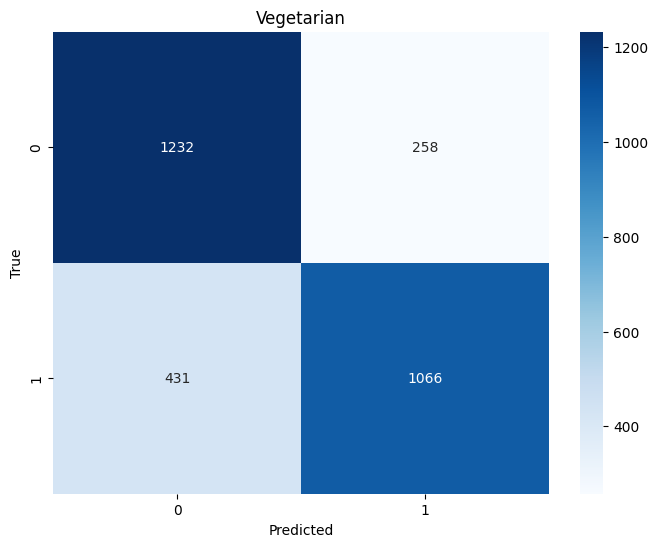

In [44]:
cm=confusion_matrix(y_test, y_pred)
plot_cm(cm,'Vegetarian')

# Multi-label Classification

Unfortunately, methods such as Logistic Regression, SVM and Random Forest do not natively support multi-label classification. The MultiOutputClassifier from scikit-learn allows us to fit, given a classifier, as much classifiers as the number of labels. <br>
This means the classifiers will all share the same hyperparameters, but not the weights or any other parameter and structure dependent on the dataset and the fit procedure.

Thus, for the above-mentioned models, we will consider the hyperparameters of the configurations which performed best in the previous classification section.

In [45]:
y=pd.read_csv(labels_path)

In [46]:
y.sum(axis=0)

Vegetarian            4990
Dairy Free              68
Gluten Free           5389
Low Carb               663
Low Fat               1737
Low Sodium            1567
Dessert                485
Meat                  3836
Fish                  1529
Dairy                 1450
Vegetarian&Dessert    4990
Meat&Fish             4965
dtype: int64

We consider these six labels for multi-label classification.

In [47]:
y=y[['Dairy Free','Gluten Free','Low Carb','Low Fat','Low Sodium','Vegetarian']]

In [48]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [49]:
scaler = StandardScaler()
X_train_scaled=scaler.fit_transform(X_train)
X_test_scaled=scaler.transform(X_test)

## Logistic Regression

In [50]:
# fitting the model
logreg=MultiOutputClassifier(LogisticRegression(), n_jobs=-1)
logreg.fit(X_train_scaled, y_train)
# predictions
y_pred = logreg.predict(X_test_scaled)
y_pred_train = logreg.predict(X_train_scaled)

print('accuracy:', accuracy_score(y_test, y_pred),'\n')
print(classification_report(y_test, y_pred))

accuracy: 0.4422497489119518 

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        17
           1       0.73      0.83      0.78      1592
           2       0.00      0.00      0.00       178
           3       0.78      0.43      0.55       517
           4       0.77      0.44      0.56       465
           5       0.75      0.72      0.73      1457

   micro avg       0.74      0.66      0.70      4226
   macro avg       0.50      0.40      0.44      4226
weighted avg       0.71      0.66      0.68      4226
 samples avg       0.52      0.48      0.48      4226



c:\Users\Giamm\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Giamm\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Giamm\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifie

Confusion Matrix:
[[2970    0]
 [  17    0]]


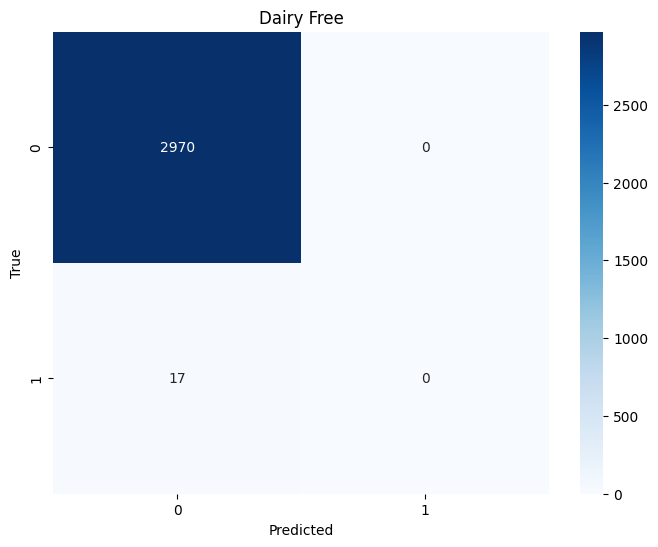

Confusion Matrix:
[[ 916  479]
 [ 275 1317]]


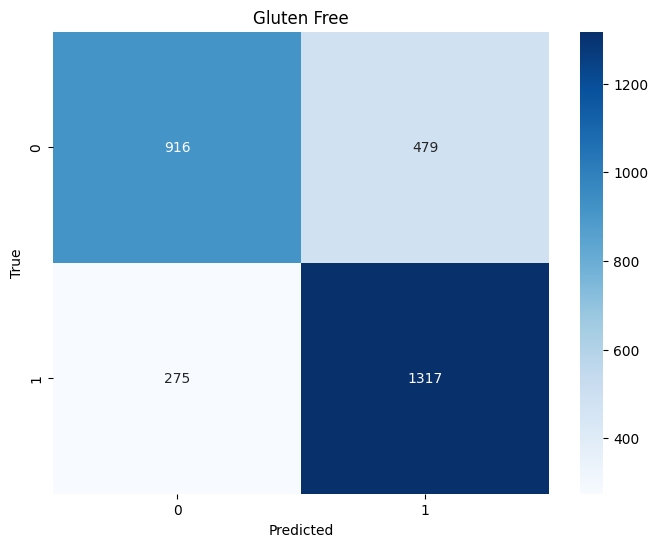

Confusion Matrix:
[[2809    0]
 [ 178    0]]


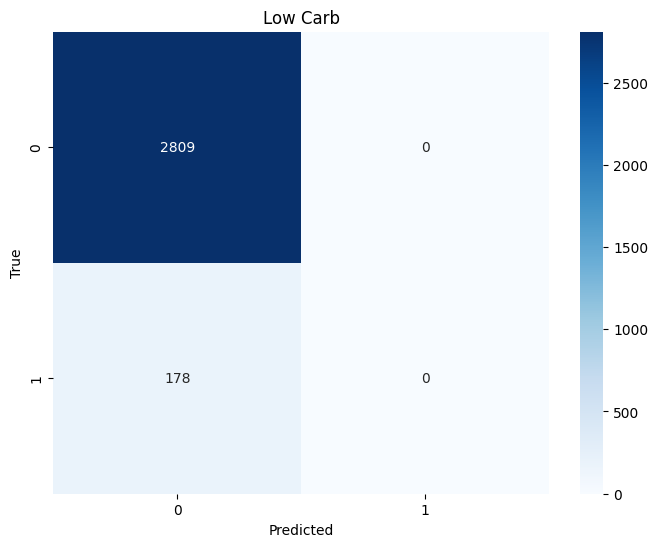

Confusion Matrix:
[[2406   64]
 [ 295  222]]


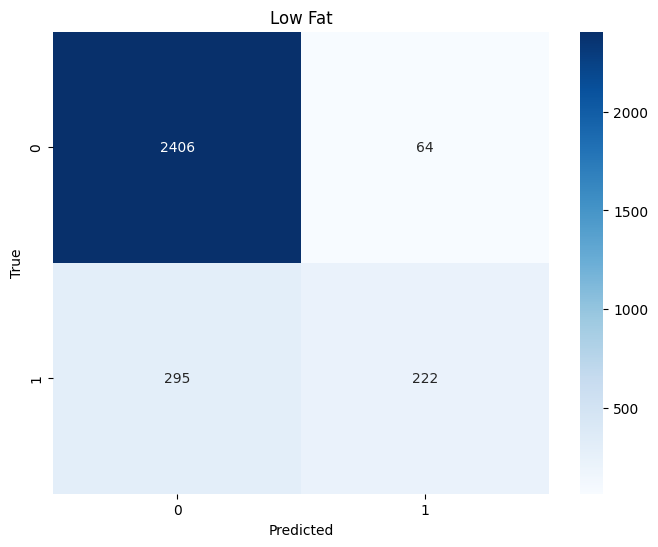

Confusion Matrix:
[[2461   61]
 [ 261  204]]


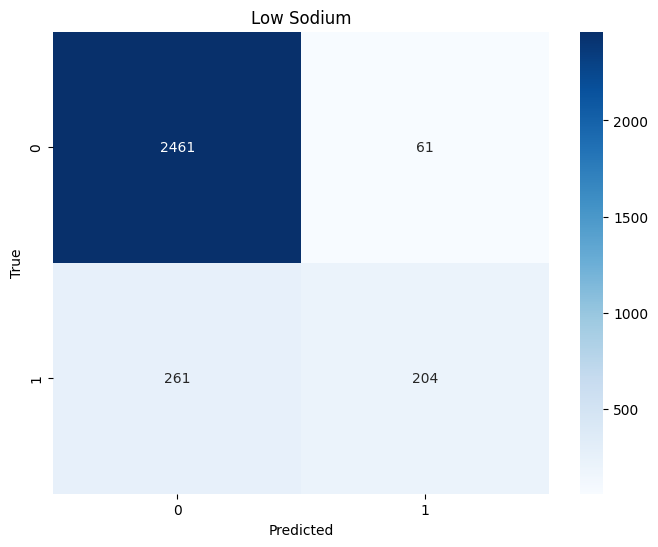

Confusion Matrix:
[[1171  359]
 [ 403 1054]]


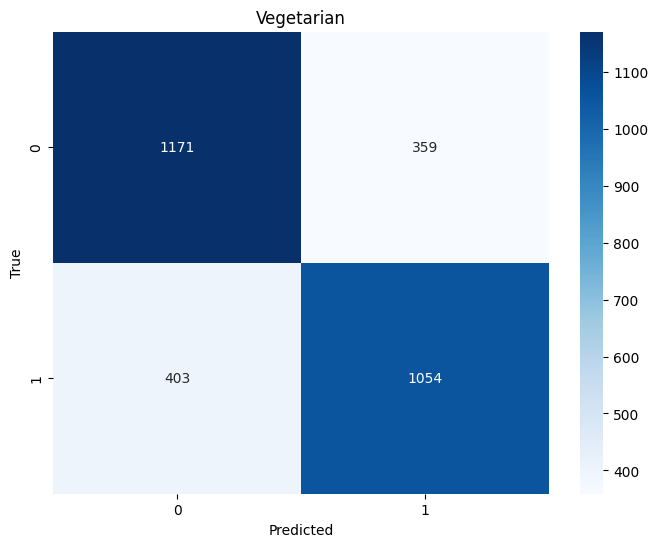

In [51]:
cm=multilabel_confusion_matrix(y_test, y_pred)

for i,col in enumerate(y_test.columns):
    plot_cm(cm[i],col)

## SVM

In [52]:
# fitting the model
svc=MultiOutputClassifier(SVC(**SVM_best_config), n_jobs=-1)
svc.fit(X_train_scaled, y_train)
# predictions
y_pred = svc.predict(X_test_scaled)
y_pred_train = svc.predict(X_train_scaled)

print('accuracy:', accuracy_score(y_test, y_pred),'\n')
print(classification_report(y_test, y_pred))

accuracy: 0.410780046869769 

              precision    recall  f1-score   support

           0       0.11      0.06      0.08        17
           1       0.75      0.76      0.75      1592
           2       0.24      0.24      0.24       178
           3       0.53      0.49      0.51       517
           4       0.58      0.54      0.56       465
           5       0.72      0.76      0.74      1457

   micro avg       0.67      0.68      0.68      4226
   macro avg       0.49      0.48      0.48      4226
weighted avg       0.67      0.68      0.67      4226
 samples avg       0.48      0.47      0.45      4226



c:\Users\Giamm\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Giamm\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Confusion Matrix:
[[2962    8]
 [  16    1]]


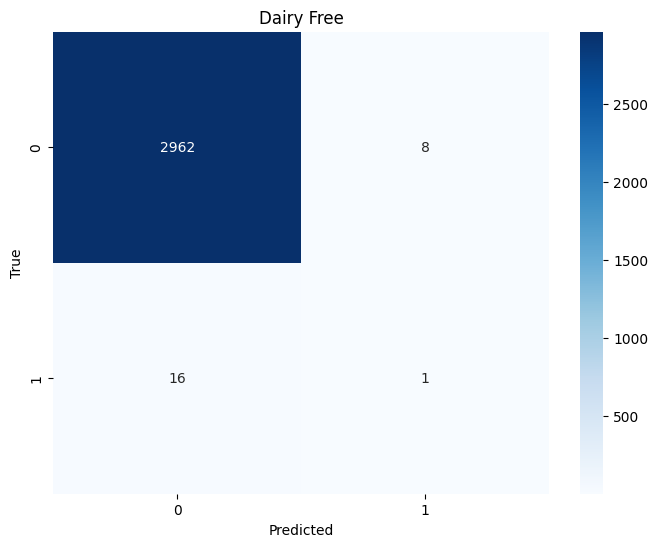

Confusion Matrix:
[[ 989  406]
 [ 384 1208]]


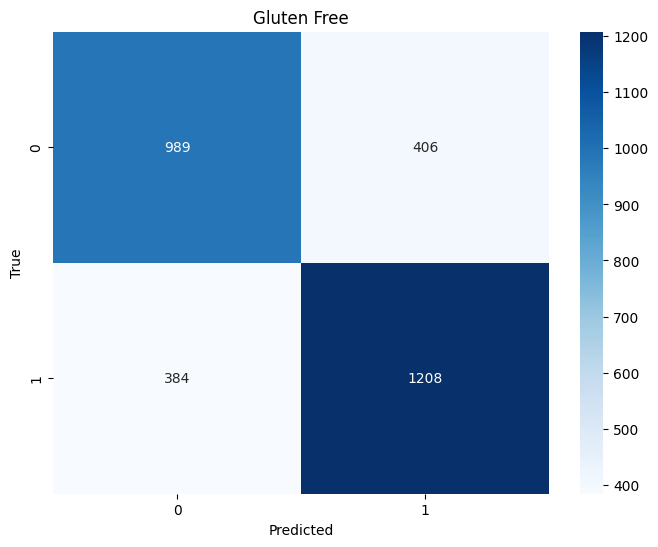

Confusion Matrix:
[[2676  133]
 [ 135   43]]


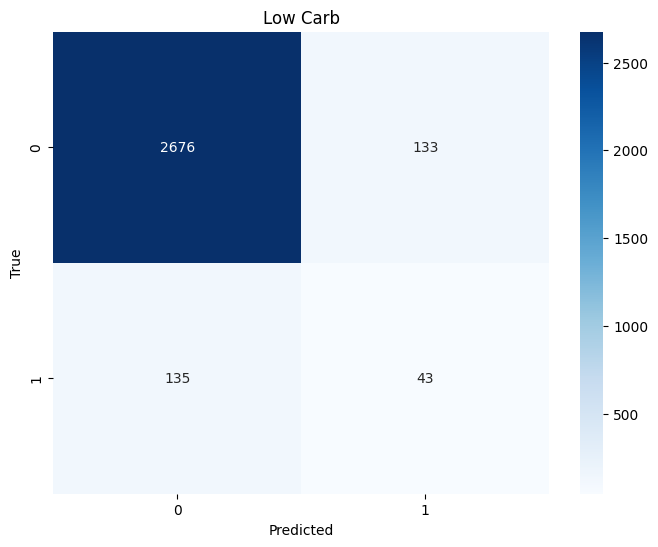

Confusion Matrix:
[[2245  225]
 [ 262  255]]


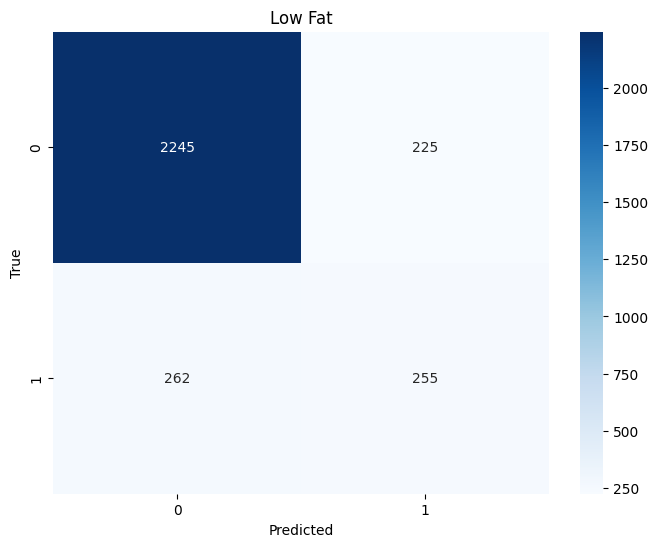

Confusion Matrix:
[[2336  186]
 [ 213  252]]


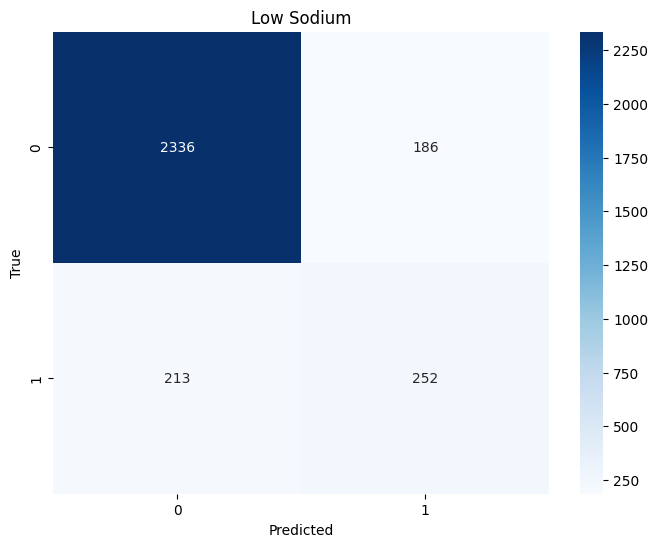

Confusion Matrix:
[[1106  424]
 [ 354 1103]]


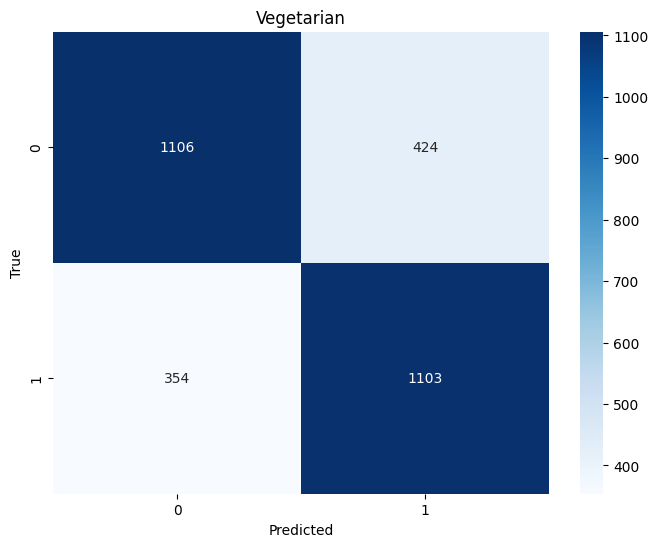

In [53]:
cm=multilabel_confusion_matrix(y_test, y_pred)

for i,col in enumerate(y_test.columns):
    plot_cm(cm[i],col)

## Random Forest

In [54]:
# fitting the model
rf=MultiOutputClassifier(RandomForestClassifier(**RF_best_config), n_jobs=-1)
rf.fit(X_train_scaled, y_train)
# predictions
y_pred = rf.predict(X_test_scaled)
y_pred_train = rf.predict(X_train_scaled)

print('accuracy:', accuracy_score(y_test, y_pred),'\n')
print(classification_report(y_test, y_pred))

accuracy: 0.4844325410110479 

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        17
           1       0.75      0.78      0.77      1592
           2       0.85      0.16      0.27       178
           3       0.79      0.49      0.61       517
           4       0.78      0.56      0.65       465
           5       0.78      0.74      0.76      1457

   micro avg       0.77      0.67      0.72      4226
   macro avg       0.66      0.45      0.51      4226
weighted avg       0.77      0.67      0.71      4226
 samples avg       0.50      0.47      0.47      4226



c:\Users\Giamm\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Giamm\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Giamm\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifie

Confusion Matrix:
[[2970    0]
 [  17    0]]


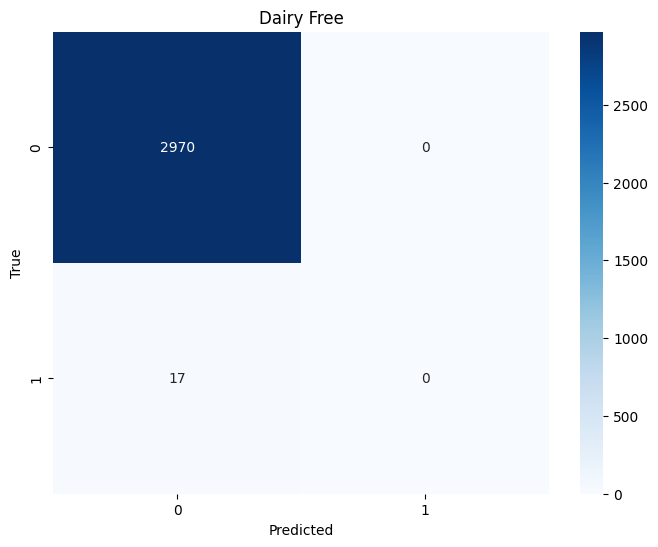

Confusion Matrix:
[[ 993  402]
 [ 355 1237]]


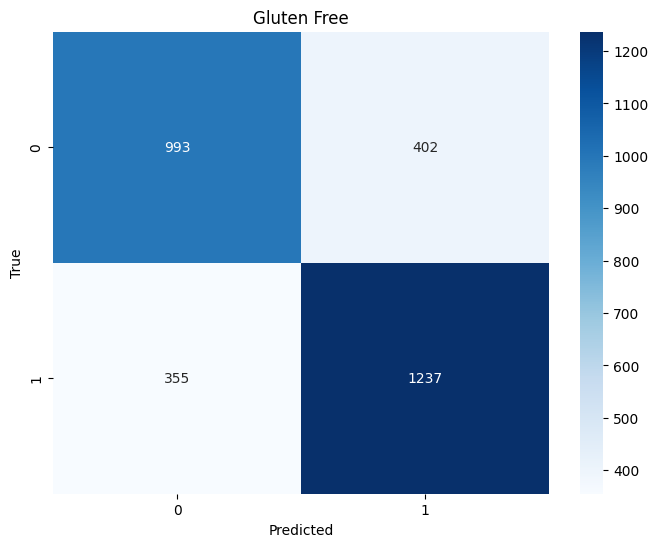

Confusion Matrix:
[[2804    5]
 [ 150   28]]


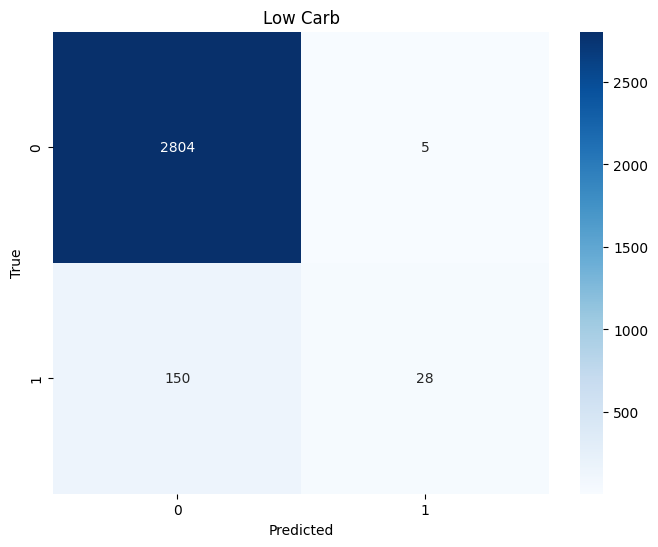

Confusion Matrix:
[[2401   69]
 [ 262  255]]


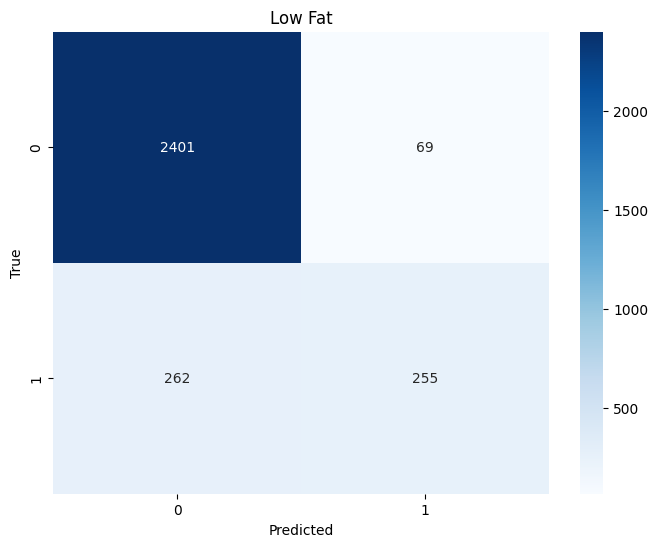

Confusion Matrix:
[[2449   73]
 [ 205  260]]


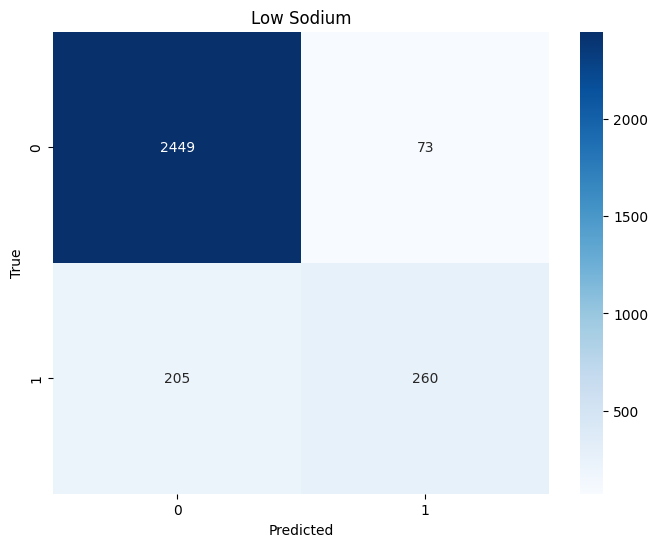

Confusion Matrix:
[[1226  304]
 [ 385 1072]]


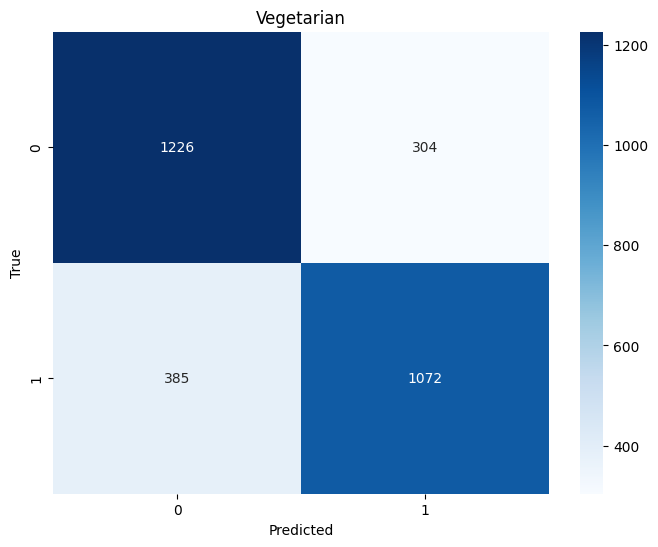

In [55]:
cm=multilabel_confusion_matrix(y_test, y_pred)

for i,col in enumerate(y_test.columns):
    plot_cm(cm[i],col)

## MLP

In [56]:
param_grid={
    'optimizer': ['adam'],
    'first_layer_size': [ 32, 64],
    'second_layer_size': [16, 32],
    'reg_strength': [0.0001, 0.001, 0.01,],
    'lr':[0.001, 0.0001]
}

In [57]:
def kfold(X, y, k):
    for i in range(k+1):
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=int(X.shape[0]/k), random_state=i)
        yield X_train, X_test, y_train, y_test

def grid_search_kfold(X,y, k, param_grid):
    best_score =0
    X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)
    for params in tqdm(ParameterGrid(param_grid)):
        #train on the k-1 folds

        model =Sequential([
                          Dense(params['first_layer_size'], activation='relu',
                                input_shape=(X.shape[1],), kernel_regularizer=l2(params['reg_strength'])),
                          Dense(params['second_layer_size'], activation='relu', kernel_regularizer=l2(params['reg_strength'])),
                          Dense(y.shape[1], activation='sigmoid', kernel_regularizer=l2(params['reg_strength']))
                          ]
                        )
        early_stopping= EarlyStopping(patience=5, restore_best_weights=True, monitor='val_loss')
        if params['optimizer']=='adam':
          opt= keras.optimizers.Adam(learning_rate=params['lr'])
        else:
          opt= keras.optimizers.SGD(learning_rate=params['lr'])
          
        model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
        model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=20, callbacks=[early_stopping], verbose=False)
        score = model.evaluate(X_test, y_test)
        print(score)
        if score[1] > best_score:
            best_score = score[1]
            best_params = params
    return best_params, best_score

In [58]:
best_params, best_score = grid_search_kfold(X_train_scaled, y_train, 3, param_grid)

  0%|          | 0/24 [00:00<?, ?it/s]

44/44 [==============================] - 0s 892us/step - loss: 0.3415 - accuracy: 0.4541


  4%|▍         | 1/24 [00:06<02:32,  6.63s/it]

[0.3415279984474182, 0.45408895611763]
44/44 [==============================] - 0s 1ms/step - loss: 0.3395 - accuracy: 0.4620


  8%|▊         | 2/24 [00:13<02:22,  6.48s/it]

[0.33954599499702454, 0.4619799256324768]
44/44 [==============================] - 0s 1ms/step - loss: 0.3575 - accuracy: 0.4849


 12%|█▎        | 3/24 [00:19<02:16,  6.49s/it]

[0.35750797390937805, 0.4849354326725006]
44/44 [==============================] - 0s 1ms/step - loss: 0.3608 - accuracy: 0.4849


 17%|█▋        | 4/24 [00:25<02:08,  6.42s/it]

[0.36080971360206604, 0.4849354326725006]
44/44 [==============================] - 0s 780us/step - loss: 0.4104 - accuracy: 0.4319


 21%|██        | 5/24 [00:32<02:01,  6.38s/it]

[0.41036054491996765, 0.431850790977478]
44/44 [==============================] - 0s 1ms/step - loss: 0.4105 - accuracy: 0.4570


 25%|██▌       | 6/24 [00:39<02:00,  6.68s/it]

[0.41053348779678345, 0.4569583833217621]
44/44 [==============================] - 0s 727us/step - loss: 0.3702 - accuracy: 0.4326


 29%|██▉       | 7/24 [00:46<01:53,  6.67s/it]

[0.37021389603614807, 0.43256816267967224]
44/44 [==============================] - 0s 1ms/step - loss: 0.3709 - accuracy: 0.4699


 33%|███▎      | 8/24 [00:52<01:46,  6.64s/it]

[0.3708929419517517, 0.4698708653450012]
44/44 [==============================] - 0s 1ms/step - loss: 0.4277 - accuracy: 0.4720


 38%|███▊      | 9/24 [00:58<01:37,  6.52s/it]

[0.42767855525016785, 0.4720229506492615]
44/44 [==============================] - 0s 784us/step - loss: 0.4289 - accuracy: 0.4813


 42%|████▏     | 10/24 [01:05<01:31,  6.57s/it]

[0.4288613796234131, 0.4813486337661743]
44/44 [==============================] - 0s 1ms/step - loss: 0.5056 - accuracy: 0.4534


 46%|████▌     | 11/24 [01:12<01:24,  6.54s/it]

[0.5056460499763489, 0.4533715844154358]
44/44 [==============================] - 0s 1ms/step - loss: 0.5064 - accuracy: 0.4326


 50%|█████     | 12/24 [01:18<01:18,  6.54s/it]

[0.5063827633857727, 0.43256816267967224]
44/44 [==============================] - 0s 1ms/step - loss: 0.3414 - accuracy: 0.4921


 54%|█████▍    | 13/24 [01:25<01:12,  6.56s/it]

[0.3414471745491028, 0.4921090304851532]
44/44 [==============================] - 0s 1ms/step - loss: 0.3422 - accuracy: 0.4871


 58%|█████▊    | 14/24 [01:32<01:06,  6.67s/it]

[0.34222474694252014, 0.48708751797676086]
44/44 [==============================] - 0s 2ms/step - loss: 0.3533 - accuracy: 0.4484


 62%|██████▎   | 15/24 [01:38<01:00,  6.69s/it]

[0.3532976508140564, 0.44835007190704346]
44/44 [==============================] - 0s 1ms/step - loss: 0.3600 - accuracy: 0.4785


 67%|██████▋   | 16/24 [01:45<00:53,  6.69s/it]

[0.3599649667739868, 0.47847920656204224]
44/44 [==============================] - 0s 1ms/step - loss: 0.4132 - accuracy: 0.4605


 71%|███████   | 17/24 [01:51<00:46,  6.61s/it]

[0.4131796061992645, 0.4605451822280884]
44/44 [==============================] - 0s 1ms/step - loss: 0.4132 - accuracy: 0.4548


 75%|███████▌  | 18/24 [01:58<00:40,  6.70s/it]

[0.413186639547348, 0.45480629801750183]
44/44 [==============================] - 0s 1ms/step - loss: 0.3731 - accuracy: 0.4620


 79%|███████▉  | 19/24 [02:05<00:33,  6.63s/it]

[0.3731231391429901, 0.4619799256324768]
44/44 [==============================] - 0s 1ms/step - loss: 0.3708 - accuracy: 0.4476


 83%|████████▎ | 20/24 [02:11<00:26,  6.59s/it]

[0.3708302080631256, 0.44763270020484924]
44/44 [==============================] - 0s 1ms/step - loss: 0.4398 - accuracy: 0.4770


 88%|████████▊ | 21/24 [02:18<00:19,  6.57s/it]

[0.4398115277290344, 0.4770444631576538]
44/44 [==============================] - 0s 1ms/step - loss: 0.4386 - accuracy: 0.4684


 92%|█████████▏| 22/24 [02:24<00:13,  6.56s/it]

[0.43859487771987915, 0.4684361517429352]
44/44 [==============================] - 0s 1ms/step - loss: 0.4829 - accuracy: 0.4699


 96%|█████████▌| 23/24 [02:31<00:06,  6.53s/it]

[0.4829470217227936, 0.4698708653450012]
44/44 [==============================] - 0s 1ms/step - loss: 0.4693 - accuracy: 0.4476


100%|██████████| 24/24 [02:37<00:00,  6.58s/it]

[0.46926048398017883, 0.44763270020484924]


In [59]:
best_params

{'first_layer_size': 64,
 'lr': 0.001,
 'optimizer': 'adam',
 'reg_strength': 0.0001,
 'second_layer_size': 16}

In [60]:
nn = Sequential([
                            Dense(best_params['first_layer_size'], activation='sigmoid',
                                    input_shape=(X_train_scaled.shape[1],), kernel_regularizer=l2(best_params['reg_strength'])),
                            Dense(best_params['second_layer_size'], activation='sigmoid', kernel_regularizer=l2(best_params['reg_strength'])),
                            Dense(y_train.shape[1], activation='sigmoid', kernel_regularizer=l2(best_params['reg_strength']))
                            ]
                            )
nn.compile(optimizer=Adam(learning_rate=best_params['lr']), loss='binary_crossentropy', metrics=['accuracy'])
early_stopping= EarlyStopping(patience=5, restore_best_weights=True, monitor='val_loss')
nn.fit(X_train_scaled, y_train, validation_data=(X_test_scaled, y_test), epochs=50, callbacks=[early_stopping], verbose=False)

In [61]:
y_pred = nn.predict(X_test_scaled)
y_pred_train = nn.predict(X_train_scaled)
y_pred = (y_pred > 0.5).astype(int)
y_pred_train = y_pred_train > 0.5

print('accuracy:', accuracy_score(y_test, y_pred),'\n')
print(classification_report(y_test, y_pred))

218/218 [==============================] - 0s 925us/step
accuracy: 0.42952795446936726 

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        17
           1       0.75      0.77      0.76      1592
           2       0.00      0.00      0.00       178
           3       0.71      0.40      0.51       517
           4       0.75      0.46      0.57       465
           5       0.77      0.68      0.72      1457

   micro avg       0.75      0.62      0.68      4226
   macro avg       0.50      0.38      0.43      4226
weighted avg       0.72      0.62      0.66      4226
 samples avg       0.48      0.44      0.44      4226



c:\Users\Giamm\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Giamm\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Giamm\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifie

Confusion Matrix:
[[2970    0]
 [  17    0]]


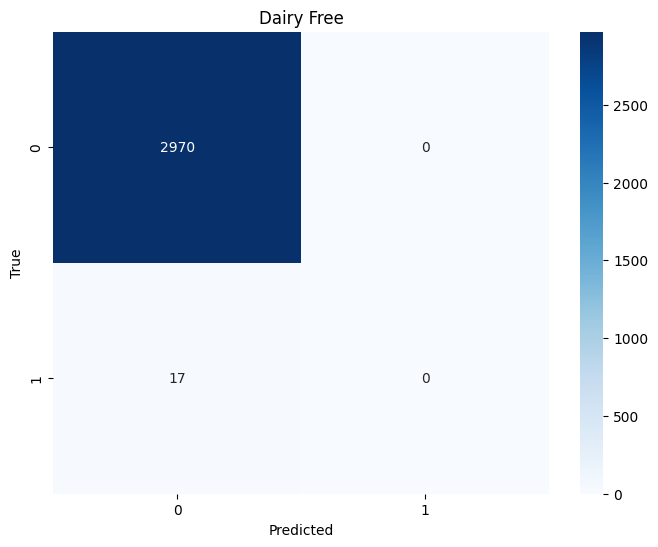

Confusion Matrix:
[[ 985  410]
 [ 370 1222]]


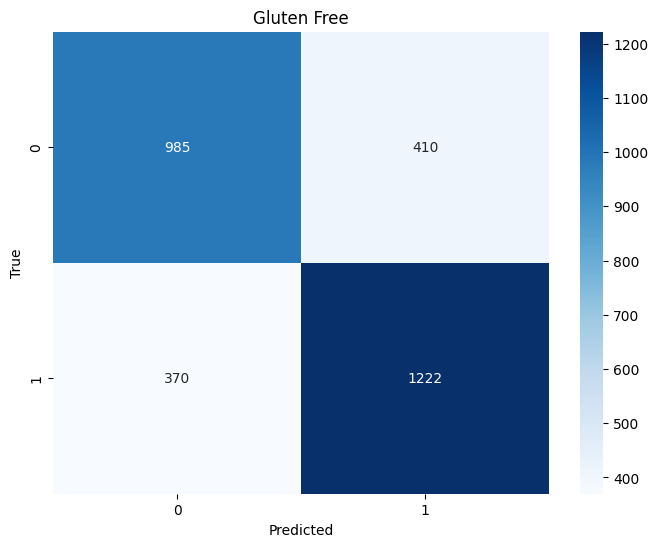

Confusion Matrix:
[[2809    0]
 [ 178    0]]


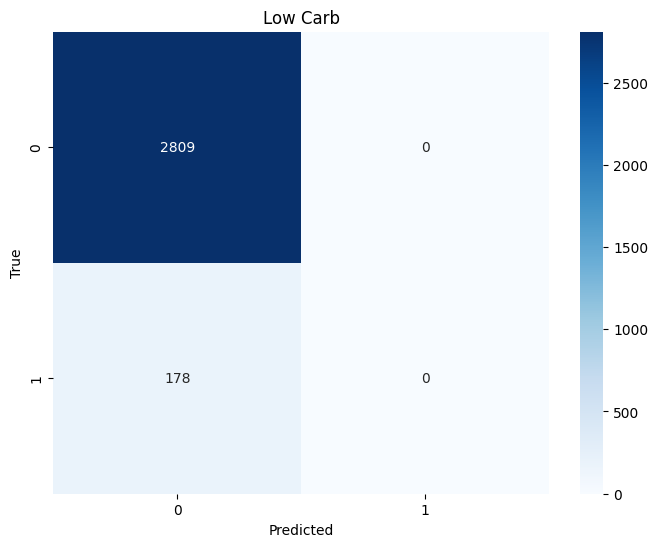

Confusion Matrix:
[[2384   86]
 [ 311  206]]


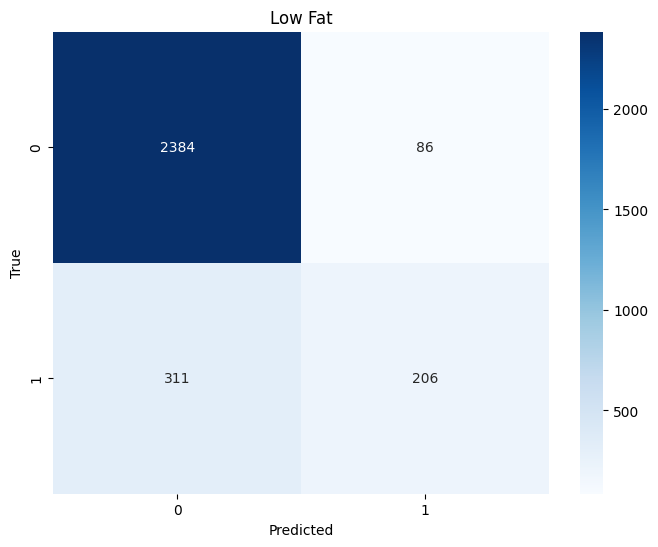

Confusion Matrix:
[[2452   70]
 [ 250  215]]


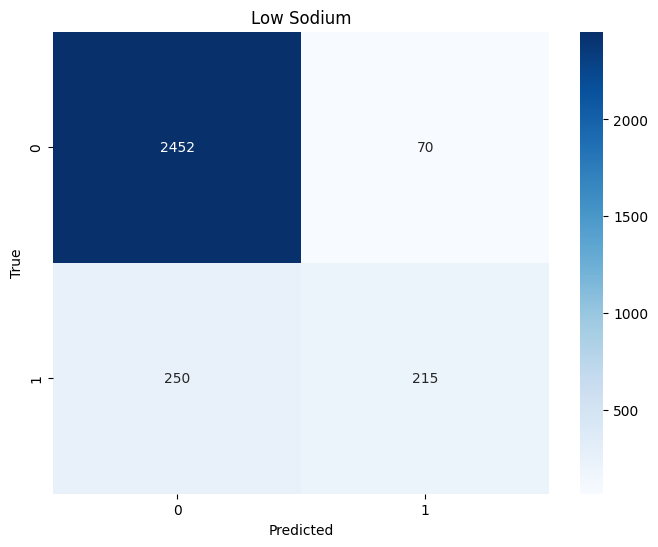

Confusion Matrix:
[[1241  289]
 [ 470  987]]


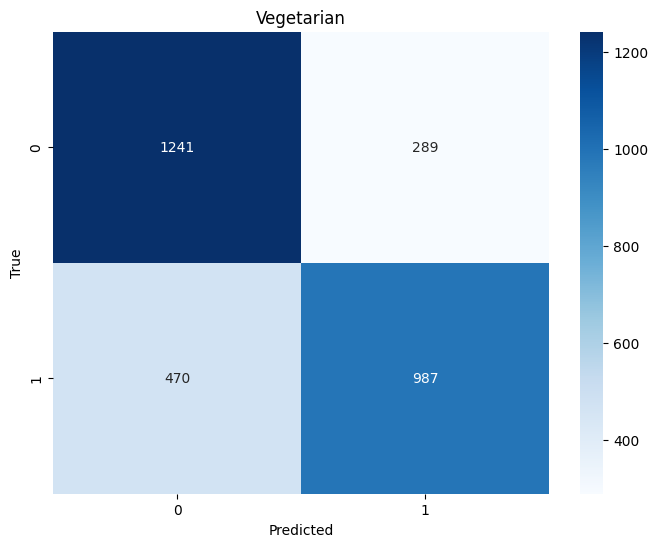

In [62]:
cm=multilabel_confusion_matrix(y_test, y_pred)

for i,col in enumerate(y_test.columns):
    plot_cm(cm[i],col)

# Final considerations

Unfortunately, Word2Vec suffers from major limitations, like the impossibility of generating a word embedding for an out-of-vocabulary word (without further training the model). <br>
Moreover, the way we created the recipe embeddings (by taking for each the midpoint of its ingredient embeddings) caused loss of information (compared to one-hot-encoding) and possibly poor representation: with this method, two recipes could be embedded very close by chance, even though they do not share any ingredient, or, on the other hand, they could be mapped far away from each other due to some ingredients being distant.<br>
Lastly, the classifiers scored decently in the single-label classification, but not as much for the multi-label task. <br> 
While this may mostly be caused by the very unbalanced dataset and the models being not designed for the task, it also suggests the need for more sofisticated methods to be deployed both for representation and classification.